2 Data Understanding

2.1 Collect initial data

import spark package for data mining and read dataset

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, trim, lower, split, count, avg, format_number,isnan,sum as _sum
from functools import reduce
from pyspark.sql.types import (StructField, StringType, IntegerType, StructType, FloatType, DoubleType)
from pyspark.ml.feature import StringIndexer, OneHotEncoder, PCA, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName('iteraction_4')\
    .config("spark.executor.heartbeatInterval", "120s") \
    .config("spark.network.timeout", "300s") \
    .getOrCreate()

# read CSV document
df1 = spark.read.csv('weather.csv', header=True, inferSchema=True)
df2 = spark.read.csv('fires.csv', header=True, inferSchema=True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 15:18:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2.2 Explore the data

In [2]:
# print DataFrame
print("Weather DataFrame:")
df1.show()
df1.printSchema()
# print the shape of DataFrame
print("Shape df1: ({}, {})".format(df1.count(), len(df1.columns)))
# print the datatype of DataFrame
print("df1 dtype:", df1.dtypes)

print("Fires DataFrame:")
df2.show()
df2.printSchema()
print("Shape df2: ({}, {})".format(df2.count(), len(df2.columns)))
print("df2 dtype:", df2.dtypes)


Weather DataFrame:
+---+---+---+-----+----+--------+
|num|  X|  Y|   DC| ISI| country|
+---+---+---+-----+----+--------+
|  1|  7|  5| 94.3| 5.1|Portugal|
|  2|  7|  4|669.1| 6.7|Portugal|
|  3|  7|  4|686.9| 6.7|Portugal|
|  4|  8|  6| 77.5| 9.0|Portugal|
|  5|  8|  6|102.2| 9.6|Portugal|
|  6|  8|  6|488.0|14.7|Portugal|
|  7|  8|  6|495.6| 8.5|Portugal|
|  8|  8|  6|608.2|10.7|Portugal|
|  9|  8|  6|692.6| 7.0|Portugal|
| 10|  7|  5|698.6| 7.1|Portugal|
| 11|  7|  5|698.6| 7.1|Portugal|
| 12|  7|  5|713.0|22.6|Portugal|
| 13|  6|  5|665.3| 0.8|Portugal|
| 14|  6|  5|686.5| 7.0|Portugal|
| 15|  6|  5|699.6| 9.2|Portugal|
| 16|  6|  5|713.9|13.9|Portugal|
| 17|  5|  5| 80.8| 7.8|Portugal|
| 18|  8|  5|664.2| 3.0|Portugal|
| 19|  6|  4| 70.8| 6.3|Portugal|
| 20|  6|  4| 97.1| 5.1|Portugal|
+---+---+---+-----+----+--------+
only showing top 20 rows

root
 |-- num: integer (nullable = true)
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- DC: double (nullable = tr

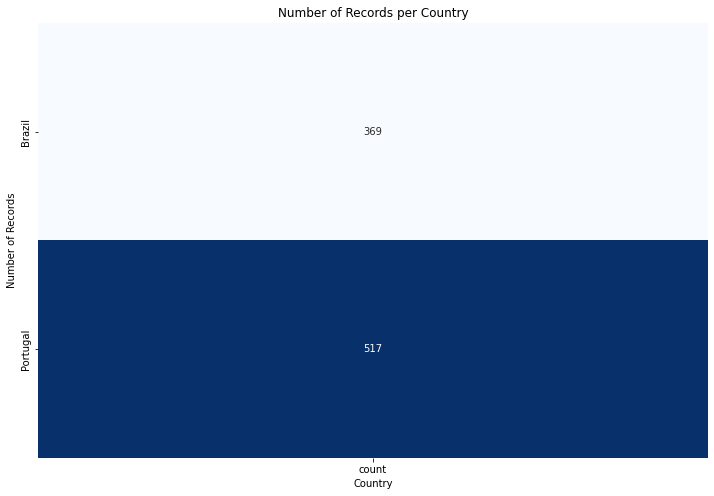

In [3]:
# integret DataFrame 1 and DataFrame 2
df3 = df1.join(df2, on=['X', 'Y', 'num', 'country'], how='outer')

country_counts = df3.groupBy('country').count().orderBy('country')

# 转换为 Pandas DataFrame
country_counts_pd = country_counts.toPandas()

# 创建一个可视化表格
plt.figure(figsize=(12, 8))
sns.heatmap(country_counts_pd.set_index('country'), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Number of Records per Country')
plt.xlabel('Country')
plt.ylabel('Number of Records')
plt.show()

Statistical Description:


+-------+------------------+------------------+------------------+--------+------------------+------------------+-----+----+-----------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|summary|                 X|                 Y|               num| country|                DC|               ISI|month| day|             FFMC|              DMC|              temp|               RH|              wind|                rain|              area|         passenger|
+-------+------------------+------------------+------------------+--------+------------------+------------------+-----+----+-----------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|  count|               886|               886|               886|     886|               886|               886|  886| 886|              517|              517|            

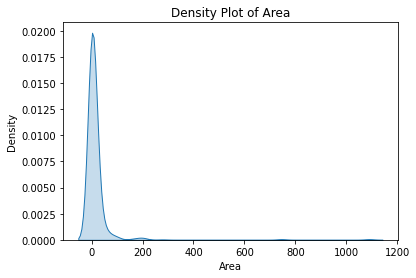

In [4]:
# 数据类型描述Statistical Description
print("Statistical Description:")
df3.describe().show()

# print datatype of integreted DataFrame(df3)
print("df3 dtype:", df3.dtypes)

# 获取 DataFrame 的形状
num_rows = df3.count()
num_cols = len(df3.columns)
print(f"Shape: ({num_rows}, {num_cols})")

# 密度图显示数据分布
if 'area' in df3.columns:
    area_pd = df3.select('area').dropna().toPandas()
    sns.kdeplot(data=area_pd['area'], fill=True)
    plt.title('Density Plot of Area')
    plt.xlabel('Area')
    plt.ylabel('Density')
    plt.show()

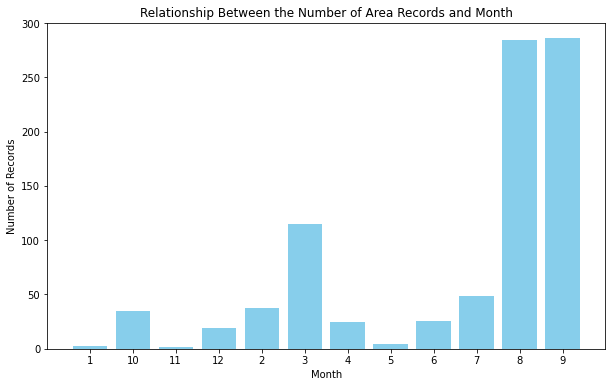

In [5]:
# clean the data, and format the values of"month" and "day"
df3 = df3.withColumn("month", 
    when(col("month") == 'jan', 1).when(col("month") == 'feb', 2).when(col("month") == 'mar', 3)
    .when(col("month") == 'apr', 4).when(col("month") == 'may', 5).when(col("month") == 'jun', 6)
    .when(col("month") == 'jul', 7).when(col("month") == 'aug', 8).when(col("month") == 'sep', 9)
    .when(col("month") == 'oct', 10).when(col("month") == 'nov', 11).when(col("month") == 'dec', 12)
    .otherwise(col("month"))
)

df3 = df3.withColumn("day", 
    when(col("day") == 'mon', 1).when(col("day") == 'tue', 2).when(col("day") == 'wed', 3)
    .when(col("day") == 'thu', 4).when(col("day") == 'fri', 5).when(col("day") == 'sat', 6)
    .when(col("day") == 'sun', 7).otherwise(col("day"))
)

df3 = df3.withColumn("country", 
    when(col("country") == 'Portugal', 1).when(col("country") == 'Brazil', 2).otherwise(col("country"))
)

# Count records by month
monthly_counts = df3.groupBy('month').agg(count('*').alias('record_count')).orderBy('month')

# Convert to Pandas DataFrame
monthly_counts_pd = monthly_counts.toPandas()

# Plot the relationship between the number of area records and month
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_pd['month'], monthly_counts_pd['record_count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.title('Relationship Between the Number of Area Records and Month')
plt.show()

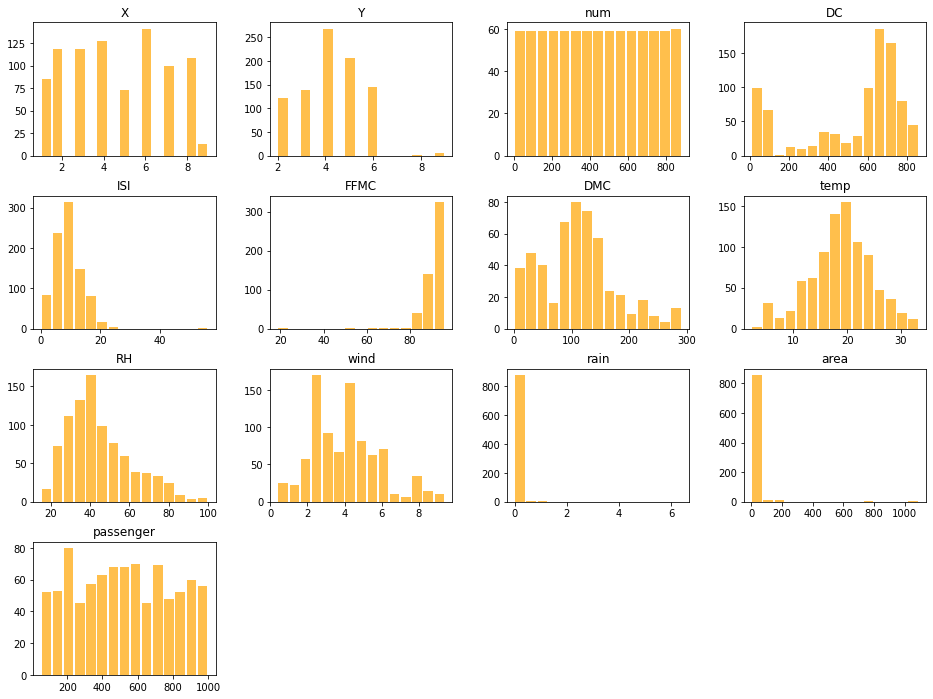

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df3_pandas = df3.toPandas()
# hist
ax = df3_pandas.hist(bins=15, color='orange', alpha=0.7, rwidth=0.85, grid=False, figsize=(16, 12))


<Figure size 432x288 with 0 Axes>

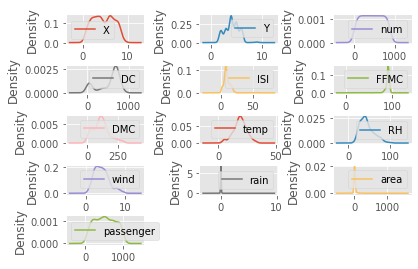

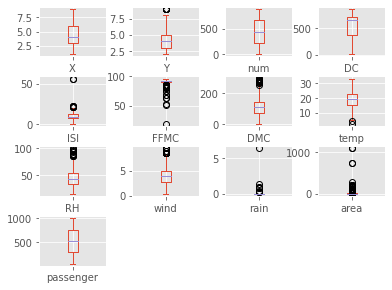

In [7]:
plt.style.use('ggplot') 
plt.tight_layout()  

plt.show()
#density graph
df3_pandas.plot(kind='density', subplots=True, layout=(5, 3), sharex=False, sharey=False)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.7)
plt.show()
#box graph
df3_pandas.plot(kind='box', subplots=True, layout=(4, 4), sharex=False, sharey=False)
plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.1, wspace=0.4, hspace=0.4)
plt.show()


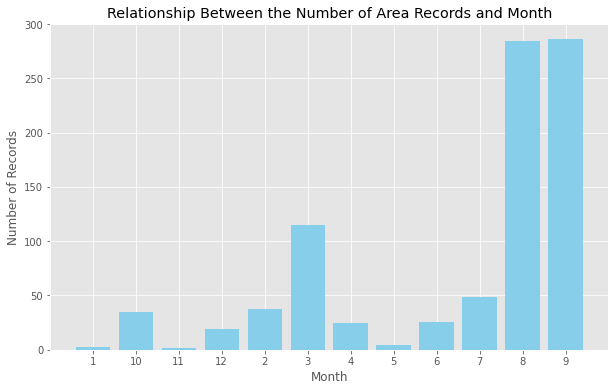

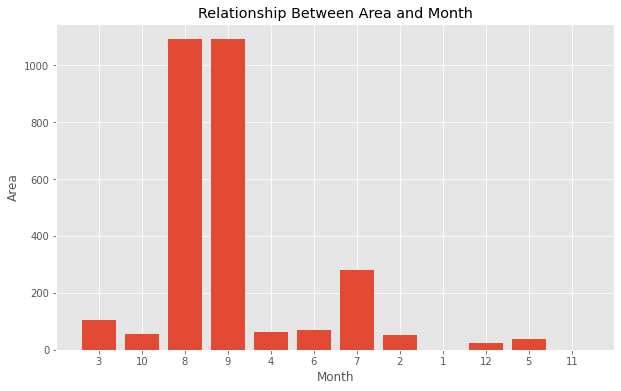

/home/ubuntu/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


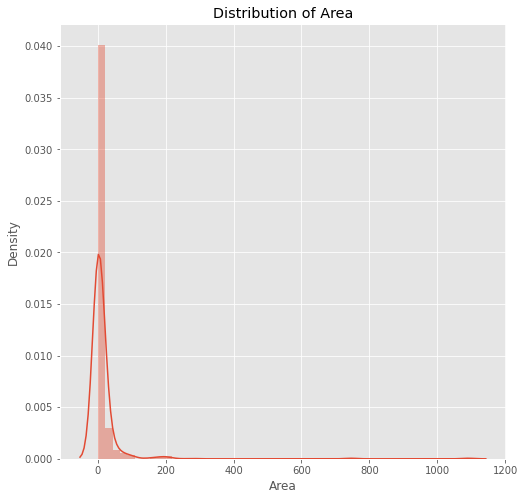

In [8]:
# 记录数量的关系Relationship Between the Number of Area Records and Month
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_pd['month'], monthly_counts_pd['record_count'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.title('Relationship Between the Number of Area Records and Month')
plt.show()

# 转换 df3 为 Pandas DataFrame
df3_pd = df3.select('month', 'area').dropna().toPandas()

# Relationship Between Area and Month
plt.figure(figsize=(10, 6))
plt.bar(df3_pd['month'], df3_pd['area'])
plt.xlabel('Month')
plt.ylabel('Area')
plt.title('Relationship Between Area and Month')
plt.show()

# rcParam setting
plt.rcParams['figure.figsize'] = [8, 8]

# Distribution of Area
sns.distplot(df3_pd['area'], kde=True, hist=True)
plt.title('Distribution of Area')
plt.xlabel('Area')
plt.ylabel('Density')
plt.show()

2.3 Explore the data

Find missing data,count missing rows by country and identify rows containing at least one missing value

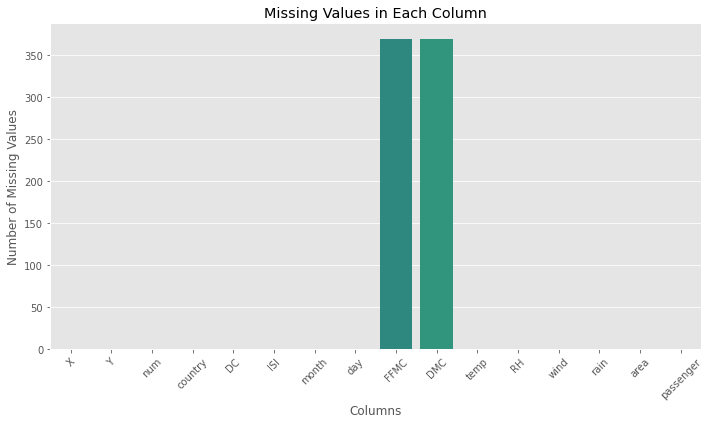

In [9]:
# 计算缺失值数量
missing_values_df1 = df1.select([(col(c).isNull().cast("int")).alias(c) for c in df1.columns]).agg(*[ _sum(c).alias(c) for c in df1.columns ])
missing_values_df2 = df2.select([(col(c).isNull().cast("int")).alias(c) for c in df2.columns]).agg(*[ _sum(c).alias(c) for c in df2.columns ])

# 将结果转换为Pandas DataFrame
missing_values_df1_pd = missing_values_df1.toPandas().melt(var_name='column', value_name='missing_count')
missing_values_df2_pd = missing_values_df2.toPandas().melt(var_name='column', value_name='missing_count')

# merge DataFrame
missing_values_pd = pd.concat([missing_values_df1_pd, missing_values_df2_pd]).groupby('column').sum().reset_index()

# count missing values in df3.columns
missing_values = df3.select([(col(c).isNull().cast("int")).alias(c) for c in df3.columns]).agg(*[_sum(c).alias(c) for c in df3.columns])

# transfer into Pandas DataFrame
missing_values_pd = missing_values.toPandas().melt(var_name='column', value_name='missing_count')

# 创建一个条形图
plt.figure(figsize=(10, 6))  
sns.barplot(data=missing_values_pd, x='column', y='missing_count', palette='viridis')
plt.title('Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()




In [10]:
# count the final rows per country
total_rows_per_country = df3.groupBy("country").agg(count("*").alias("total_count"))
condition = reduce(lambda x, y: x | y, [col(c).isNull() for c in df3.columns])
missing_rows_per_country = df3.filter(condition).groupBy("country").agg(count("*").alias("missing_count"))

# count missing rate
missing_ratio_per_country = missing_rows_per_country.join(
    total_rows_per_country,
    on="country",
    how="inner"
).withColumn(
    "missing_ratio",
    col("missing_count") / col("total_count")
).select(
    "country",
    "missing_ratio"
).orderBy(col("missing_ratio").desc())

# show result
missing_ratio_per_country.show()

+-------+-------------+
|country|missing_ratio|
+-------+-------------+
|      2|          1.0|
+-------+-------------+



2.4 Verify the data quality

Visualise the rate of missing data

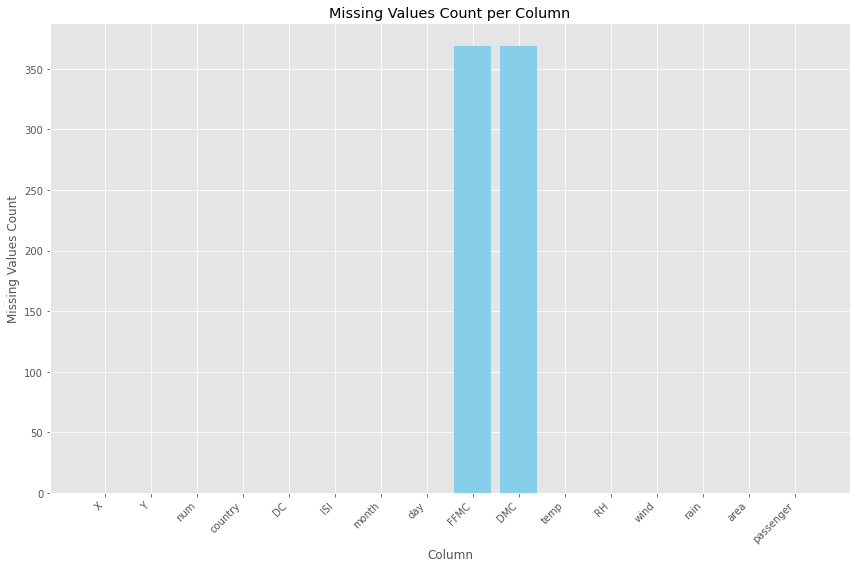

In [11]:
import matplotlib.pyplot as plt

# 设置绘图参数
plt.figure(figsize=(12, 8))
plt.bar(missing_values_pd['column'], missing_values_pd['missing_count'], color='skyblue')
plt.xlabel('Column')
plt.ylabel('Missing Values Count')
plt.title('Missing Values Count per Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# show image
plt.show()


3.Data processing

3.1 select data

In [12]:
# 转换数据类型
df3 = df3.withColumn("month", col("month").cast("int"))
df3 = df3.withColumn("day", col("day").cast("int"))
df3 = df3.withColumn("country", col("country").cast("int"))

# check structure of median_values
median_values = df3.approxQuantile(["FFMC", "DMC"], [0.5], 0.25)
print("Median Values:", median_values)

# use median value fill missing data
if len(median_values) > 1 and len(median_values[0]) > 0 and len(median_values[1]) > 0:
    median_dict = {"FFMC": median_values[0][0], "DMC": median_values[1][0]}
    df4 = df3.fillna(median_dict)
else:
    print("Error: Median values not calculated correctly.")
    df4 = df3  

# check data
df4.show(20)
print("Statistical Description:")
df4.describe().show()

# Verify datatype
print("Data Types:", df4.dtypes)

# Check missing value after filling
df4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4.columns]).show()

# change intoPandas DataFrame
df = df4.toPandas()

# special column
numeric_columns = ["area", "DC", "ISI", "month", "FFMC", "DMC", "temp", "RH", "wind", "rain", "passenger"]

# correlation_matrix
correlation_matrix = df[numeric_columns].corr()

# correlations varible ofarea
area_correlations = correlation_matrix["area"].drop("area").reset_index()
area_correlations.columns = ["Variable", "Correlation"]

# sort by AbsCorrelation
area_correlations["AbsCorrelation"] = area_correlations["Correlation"].abs()
sorted_area_correlations = area_correlations.sort_values(by="AbsCorrelation", ascending=False)

for index, row in sorted_area_correlations.iterrows():
    print(f"Correlation between area and {row['Variable']}: {row['Correlation']}")

Median Values: [[90.2], [68.6]]
+---+---+---+-------+-----+----+-----+---+----+-----+----+---+----+----+------+---------+
|  X|  Y|num|country|   DC| ISI|month|day|FFMC|  DMC|temp| RH|wind|rain|  area|passenger|
+---+---+---+-------+-----+----+-----+---+----+-----+----+---+----+----+------+---------+
|  1|  2| 79|      1|529.8|12.5|    8|  5|90.1|108.0|14.7| 66| 2.7| 0.0|   0.0|      752|
|  1|  2| 80|      1|561.6| 7.0|    8|  2|91.0|121.2|21.6| 19| 6.7| 0.0|   0.0|      464|
|  1|  2| 81|      1|601.4|10.6|    8|  7|91.4|142.4|19.5| 39| 6.3| 0.0|   0.0|      446|
|  1|  2| 82|      1|631.2| 6.3|    8|  7|90.2| 99.6|17.9| 44| 2.2| 0.0|   0.0|      594|
|  1|  2| 83|      1|647.1|17.0|    8|  2|94.8|108.3|18.6| 51| 4.5| 0.0|   0.0|      489|
|  1|  2| 84|      1|654.1| 9.6|    8|  3|92.1|111.2|16.6| 47| 0.9| 0.0|   0.0|      614|
|  1|  2| 85|      1|661.3| 6.3|    8|  4|91.7|114.3|20.2| 45| 3.6| 0.0|   0.0|      867|
|  1|  2| 86|      1|706.4| 9.2|    9|  4|92.9|137.0|21.5| 15| 0.9| 

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|summary|                 X|                 Y|               num|            country|                DC|               ISI|            month|               day|             FFMC|              DMC|              temp|               RH|              wind|                rain|              area|         passenger|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|  count|               886|               886|              

3.2 construct data

In [13]:
from pyspark.sql import functions as F

# Identify quarter
def get_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4
    else:
        return None

# register UDF (User Defined Function)
get_quarter_udf = F.udf(get_quarter, IntegerType())

# add quarter column
df4 = df4.withColumn('quarter', get_quarter_udf(F.col('month')))

# showtop 30 rows
df4.select('month', 'quarter').show(30)


+-----+-------+
|month|quarter|
+-----+-------+
|    8|      3|
|    8|      3|
|    8|      3|
|    8|      3|
|    8|      3|
|    8|      3|
|    8|      3|
|    9|      3|
|    9|      3|
|    9|      3|
|    9|      3|
|    8|      3|
|    7|      3|
|    9|      3|
|    8|      3|
|    7|      3|
|    8|      3|
|    8|      3|
|    8|      3|
|    9|      3|
|    8|      3|
|    9|      3|
|    8|      3|
|    7|      3|
|    9|      3|
|    8|      3|
|    3|      1|
|    9|      3|
|    9|      3|
|    9|      3|
+-----+-------+
only showing top 30 rows



In [14]:
# delete the rows contain "Brazil (country=2 in the dataset)" 
df4_1 = df4.filter(df4['country'] != 2)
df4_1.show()

# drop num, country, and passenger 
df5 = df4_1.drop('num', 'country', 'passenger')
df5.show()

# save new dataframe as CSV 
df5.coalesce(1).write.option("header", "true").csv("forestfire.csv")


+---+---+---+-------+-----+----+-----+---+----+-----+----+---+----+----+------+---------+-------+
|  X|  Y|num|country|   DC| ISI|month|day|FFMC|  DMC|temp| RH|wind|rain|  area|passenger|quarter|
+---+---+---+-------+-----+----+-----+---+----+-----+----+---+----+----+------+---------+-------+
|  1|  2| 79|      1|529.8|12.5|    8|  5|90.1|108.0|14.7| 66| 2.7| 0.0|   0.0|      752|      3|
|  1|  2| 80|      1|561.6| 7.0|    8|  2|91.0|121.2|21.6| 19| 6.7| 0.0|   0.0|      464|      3|
|  1|  2| 81|      1|601.4|10.6|    8|  7|91.4|142.4|19.5| 39| 6.3| 0.0|   0.0|      446|      3|
|  1|  2| 82|      1|631.2| 6.3|    8|  7|90.2| 99.6|17.9| 44| 2.2| 0.0|   0.0|      594|      3|
|  1|  2| 83|      1|647.1|17.0|    8|  2|94.8|108.3|18.6| 51| 4.5| 0.0|   0.0|      489|      3|
|  1|  2| 84|      1|654.1| 9.6|    8|  3|92.1|111.2|16.6| 47| 0.9| 0.0|   0.0|      614|      3|
|  1|  2| 85|      1|661.3| 6.3|    8|  4|91.7|114.3|20.2| 45| 3.6| 0.0|   0.0|      867|      3|
|  1|  2| 86|      1

AnalysisException: path file:/home/ubuntu/test/forestfire.csv already exists.

7.0 Data mining

7.1 Logistic Regression modeling, using the binary classification method 

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import expr

# Initialize Spark session
spark = SparkSession.builder.appName("ForestFirePrediction").getOrCreate()

# Load data
df6 = spark.read.csv("forestfire.csv", header=True, inferSchema=True)

# Convert the area column to binary labels
df7 = df6.withColumn("label", when(col("area") > 0, 1).otherwise(0))

# Select feature columns
feature_columns = ["FFMC", "DMC", "temp", "RH", "wind", "rain", "month", "day", "quarter"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df7)

# Split the dataset into training and test sets
(train_data, test_data) = df_vector.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Parameter grid
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                .addGrid(lr.maxIter, [10, 50, 100])
                .build())

# Create evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Create CrossValidator
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=5)

# Train the model
cvModel_lr = cv_lr.fit(train_data)

# Make predictions on the test set
lr_predictions = cvModel_lr.transform(test_data)

# Evaluate the model
lr_auc = evaluator.evaluate(lr_predictions)
print(f"AUC for Logistic Regression: {lr_auc}")

# Get the best parameters
best_model_lr = cvModel_lr.bestModel
best_params = {param.name: best_model_lr.getOrDefault(param) for param in paramGrid_lr[0]}
print("Best parameters for Logistic Regression:", best_params)

# View coefficients and intercept of the best model
print("Coefficients: " + str(best_model_lr.coefficients))
print("Intercept: " + str(best_model_lr.intercept))

# Show detailed prediction results
lr_predictions.select("features", "label", "rawPrediction", "probability", "prediction").show()

# Calculate additional evaluation metrics
tp = lr_predictions.filter((col('prediction') == 1) & (col('label') == 1)).count()
tn = lr_predictions.filter((col('prediction') == 0) & (col('label') == 0)).count()
fp = lr_predictions.filter((col('prediction') == 1) & (col('label') == 0)).count()
fn = lr_predictions.filter((col('prediction') == 0) & (col('label') == 1)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if tp + fp != 0 else 0
recall = tp / (tp + fn) if tp + fn != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

# Stop Spark session
spark.stop()


AUC for Logistic Regression: 0.6945488721804511
Best parameters for Logistic Regression: {'regParam': 1.0, 'maxIter': 10}
Coefficients: [0.004035237190837936,-5.7785852496519835e-06,0.000806496714142645,-0.0005929290347744648,0.013439917230515795,0.03041101350092039,0.010641192520583511,-0.009138149272646902,0.028052440075028134]
Intercept: -0.40337898940310163
+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[95.5,99.9,23.3,3...|    1|[-0.1841714951261...|[0.45408683084464...|       1.0|
|[90.2,99.6,17.9,4...|    0|[-0.0832589051610...|[0.47919728943256...|       1.0|
|[92.1,111.2,16.6,...|    0|[-0.1071122960929...|[0.47324749880574...|       1.0|
|[92.9,137.0,25.4,...|    0|[-0.1481220857737...|[0.46303703494735...|       1.0|
|[87.6,52.2,8.3,72...|    0|[-0.0063107903666...|[0.4984223076

7.2 RandomForestRegression modeling 

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("RandomForestRegression").getOrCreate()

# Load data
df = spark.read.csv("forestfire.csv", header=True, inferSchema=True)

# Feature columns and label column
feature_columns = df.columns[:-1]  # Assuming the last column is the label
label_column = df.columns[-1]

# Data preprocessing: convert features and label into feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df).select("features", col(label_column).alias("label"))

# Initialize arrays to store results
mae_scores = []
mse_scores = []
r2_scores = []

# Perform multiple iterations to observe variation
num_iterations = 5
for i in range(num_iterations):
    # Split dataset into training set and test set
    (train_data, test_data) = df_vector.randomSplit([0.8, 0.2], seed=42 + i)

    # Random Forest Regressor
    rf = RandomForestRegressor(featuresCol='features', labelCol='label', seed=42 + i)

    # Parameter grid
    paramGrid = (ParamGridBuilder()
                 .addGrid(rf.maxDepth, [5, 10, 15])
                 .addGrid(rf.numTrees, [20, 50, 100])
                 .build())

    # Evaluator
    evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
    evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
    evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')

    # CrossValidator
    crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator_r2, numFolds=10)

    # Train model with CrossValidator
    cv_model = crossval.fit(train_data)

    # Predict on the test set
    predictions = cv_model.transform(test_data)

    # Calculate evaluation metrics
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    mse = evaluator_mse.evaluate(predictions)

    # Store results
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"Iteration {i+1}: R2 = {r2:.3f}, MAE = {mae:.3f}, MSE = {mse:.3f}")

# Calculate average and standard deviation of R2, MAE, and MSE
avg_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)
avg_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
avg_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Average R2: {avg_r2:.3f} ± {std_r2:.3f}")
print(f"Average MAE: {avg_mae:.3f} ± {std_mae:.3f}")
print(f"Average MSE: {avg_mse:.3f} ± {std_mse:.3f}")

# Print best model parameters
best_model = cv_model.bestModel
best_params = {param.name: best_model.getOrDefault(param) for param in paramGrid[0]}
print("Best parameters for Random Forest Regressor:", best_params)

# Stop Spark session
spark.stop()


Iteration 1: R2 = 0.988, MAE = 0.032, MSE = 0.009


Iteration 2: R2 = 0.994, MAE = 0.026, MSE = 0.004


Iteration 3: R2 = 0.990, MAE = 0.027, MSE = 0.005
Iteration 4: R2 = 0.957, MAE = 0.044, MSE = 0.027
Iteration 5: R2 = 0.976, MAE = 0.030, MSE = 0.012
Average R2: 0.981 ± 0.013
Average MAE: 0.032 ± 0.006
Average MSE: 0.011 ± 0.008
Best parameters for Random Forest Regressor: {'maxDepth': 10, 'numTrees': 100}


7.3 Search for patterns

7.3.1 Feature importance with the happen of a fire

24/05/24 15:20:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/24 15:20:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


AUC for Logistic Regression: 0.6914160401002507
Coefficients:  [0.004181426291480304,1.7487046249645343e-05,0.0010065599892038952,-0.0005937059366466634,0.013315956137563804,0.030569500873971093,0.01235665194277272,-0.009232182121630664]
Intercept:  -0.358885620417138


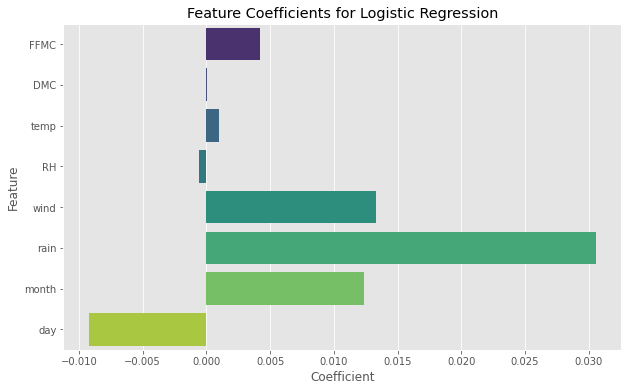

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("FireOccurrencePrediction").getOrCreate()

# Load data
df = spark.read.csv("forestfire.csv", header=True, inferSchema=True)

# Convert the area column to binary labels
df = df.withColumn("label", when(col("area") > 0, 1).otherwise(0))

# Select feature columns
feature_columns = ["FFMC", "DMC", "temp", "RH", "wind", "rain", "month", "day"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df)

# Split the dataset into training and test sets
(train_data, test_data) = df_vector.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Parameter grid
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                .addGrid(lr.maxIter, [10, 50, 100])
                .build())

# Create evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Create CrossValidator
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=5)

# Train the model
cvModel_lr = cv_lr.fit(train_data)

# Make predictions on the test set
lr_predictions = cvModel_lr.transform(test_data)

# Evaluate the model
lr_auc = evaluator.evaluate(lr_predictions)
print(f"AUC for Logistic Regression: {lr_auc}")

# Get the best model coefficients
best_model_lr = cvModel_lr.bestModel
coefficients = best_model_lr.coefficients
intercept = best_model_lr.intercept
print("Coefficients: ", coefficients)
print("Intercept: ", intercept)

# Convert coefficients to pandas DataFrame for visualization
coef_df = pd.DataFrame({
    "Feature": feature_columns,
    "Coefficient": coefficients.toArray()
})

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis")
plt.title("Feature Coefficients for Logistic Regression")
plt.show()

# Stop Spark session
spark.stop()


7.3.2 Feature importance with the size of a fire

24/05/24 15:20:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Random Forest Regressor: R2 = 0.992, MAE = 0.031, CV MSE = 0.006
Best parameters for Random Forest Regressor: {'maxDepth': 10, 'numTrees': 50}
Feature Importances:
month: 0.5863112881783678
DC: 0.25359411064460774
DMC: 0.07517772560413112
temp: 0.03866345694911556
FFMC: 0.01160033190847629
ISI: 0.009830389092939472
wind: 0.007851541281652085
RH: 0.007806564006756788
day: 0.003251687838148812
X: 0.0022874694713543144
area: 0.002011782662126182
Y: 0.001613652362323805
rain: 0.0


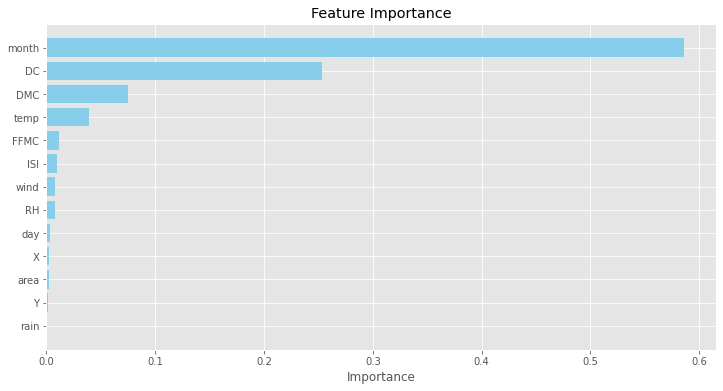

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("RandomForestRegression").getOrCreate()

# Load data (assuming the dataset is stored in df)
df = spark.read.csv("forestfire.csv", header=True, inferSchema=True)

# Feature columns and label column
feature_columns = df.columns[:-1]  # Assuming the last column is the label
label_column = df.columns[-1]

# Data preprocessing: convert features and label into feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df).select("features", col(label_column).alias("label"))

# Split dataset into training set and test set
(train_data, test_data) = df_vector.randomSplit([0.8, 0.2], seed=42)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label')

# Parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.numTrees, [20, 50, 100])
             .build())

# Evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

# CrossValidator
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

# Train model with CrossValidator
cv_model = crossval.fit(train_data)

# Predict on the test set
predictions = cv_model.transform(test_data)

# Calculate evaluation metrics
r2 = evaluator.evaluate(predictions)
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = evaluator_mae.evaluate(predictions)
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')
cv_mse = evaluator_mse.evaluate(predictions)

# Print results
print(f"Random Forest Regressor: R2 = {r2:.3f}, MAE = {mae:.3f}, CV MSE = {cv_mse:.3f}")

# Best model parameters
best_model = cv_model.bestModel
best_params = {param.name: best_model.getOrDefault(param) for param in paramGrid[0]}
print("Best parameters for Random Forest Regressor:", best_params)

# Feature importance
print("Feature Importances:")
feature_importances = best_model.featureImportances
sorted_feature_importance_pairs = sorted(zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True)

# Extract sorted features and their importance
sorted_features, sorted_importance = zip(*sorted_feature_importance_pairs)

for feature, importance in zip(sorted_features, sorted_importance):
    print(f"{feature}: {importance}")

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important features at the top
plt.show()

# Stop Spark session
spark.stop()


7.3.3 Inter-correlation analysis of factors

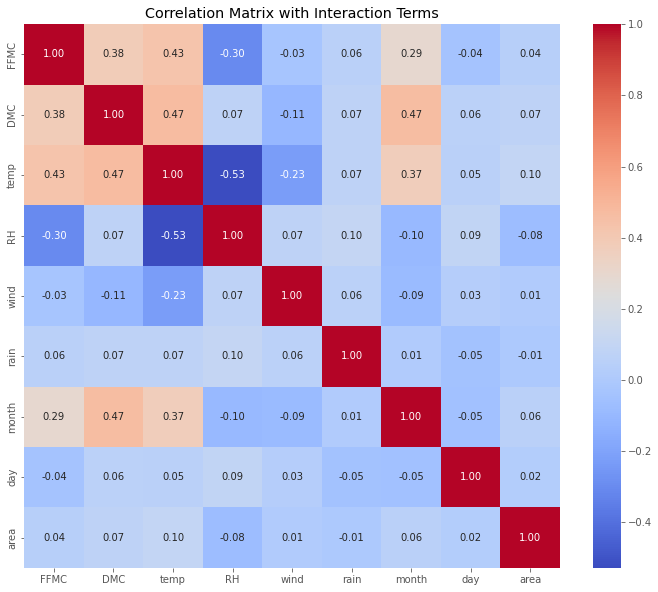

In [17]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("FeatureCorrelationAnalysis").getOrCreate()

# Load data
df = spark.read.csv("forestfire.csv", header=True, inferSchema=True)

# Select feature columns and label column
feature_columns = ["FFMC", "DMC", "temp", "RH", "wind", "rain", "month", "day"]
label_column = "area"

# Convert Spark DataFrame to Pandas DataFrame for correlation analysis
pandas_df = df.select(feature_columns + [label_column]).toPandas()

# Calculate correlation matrix
correlation_matrix = pandas_df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix with Interaction Terms")
plt.show()

# Stop Spark session
spark.stop()


8 Interpretation

Random Forest Regressor: R2 = 0.992, MAE = 0.031, CV MSE = 0.006
Best parameters for Random Forest Regressor: {'maxDepth': 10, 'numTrees': 50}
Feature Importances:
month: 0.5863112881783678
DC: 0.25359411064460774
DMC: 0.07517772560413112
temp: 0.03866345694911556
FFMC: 0.01160033190847629
ISI: 0.009830389092939472
wind: 0.007851541281652085
RH: 0.007806564006756788
day: 0.003251687838148812
X: 0.0022874694713543144
area: 0.002011782662126182
Y: 0.001613652362323805
rain: 0.0


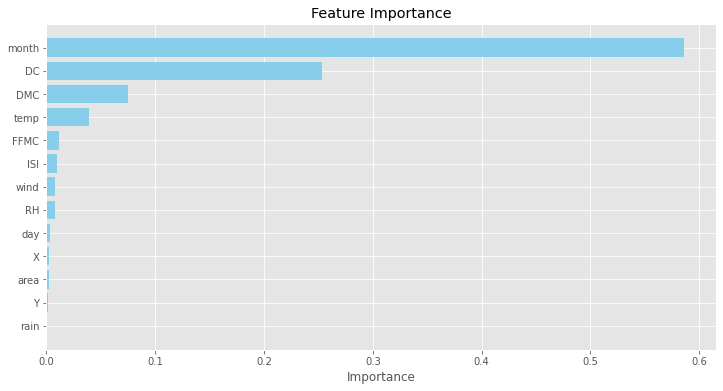

Best Model Details:
Number of Trees: 50
Max Depth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_a6c3f033ec94, numTrees=50, numFeatures=13>
Feature Importances: (13,[0,1,2,3,4,5,6,7,8,9,10,12],[0.0022874694713543144,0.001613652362323805,0.25359411064460774,0.009830389092939472,0.5863112881783678,0.003251687838148812,0.01160033190847629,0.07517772560413112,0.03866345694911556,0.007806564006756788,0.007851541281652085,0.002011782662126182])
Tree 0:
DecisionTreeRegressionModel: uid=dtr_0c9229486ecd, depth=5, numNodes=19, numFeatures=13
  If (feature 7 <= 52.75)
   If (feature 2 <= 105.25)
    If (feature 4 <= 3.5)
     Predict: 1.0
    Else (feature 4 > 3.5)
     Predict: 2.0
   Else (feature 2 > 105.25)
    If (feature 5 <= 5.5)
     If (feature 1 <= 7.5)
      Predict: 4.0
     Else (feature 1 > 7.5)
      Predict: 3.0
    Else (feature 5 > 5.5)
     If (feature 4 <= 5.5)
      If (feature 10 <= 4.25)
       Predict: 1.0
      El

In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("RandomForestRegression").getOrCreate()

# Load data
df = spark.read.csv("forestfire.csv", header=True, inferSchema=True)

# Feature columns and label column
feature_columns = df.columns[:-1]  # Assuming the last column is the label
label_column = df.columns[-1]

# Data preprocessing: convert features and label into feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vector = assembler.transform(df).select("features", col(label_column).alias("label"))

# Split dataset into training set and test set
(train_data, test_data) = df_vector.randomSplit([0.8, 0.2], seed=42)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label')

# Parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.numTrees, [20, 50, 100])
             .build())

# Evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

# CrossValidator
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

# Train model with CrossValidator
cv_model = crossval.fit(train_data)

# Predict on the test set
predictions = cv_model.transform(test_data)

# Calculate evaluation metrics
r2 = evaluator.evaluate(predictions)
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
mae = evaluator_mae.evaluate(predictions)
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')
cv_mse = evaluator_mse.evaluate(predictions)

# Print results
print(f"Random Forest Regressor: R2 = {r2:.3f}, MAE = {mae:.3f}, CV MSE = {cv_mse:.3f}")

# Best model parameters
best_model = cv_model.bestModel
best_params = {param.name: best_model.getOrDefault(param) for param in paramGrid[0]}
print("Best parameters for Random Forest Regressor:", best_params)

# Feature importance
print("Feature Importances:")
feature_importances = best_model.featureImportances
sorted_feature_importance_pairs = sorted(zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True)

# Extract sorted features and their importance
sorted_features, sorted_importance = zip(*sorted_feature_importance_pairs)

for feature, importance in zip(sorted_features, sorted_importance):
    print(f"{feature}: {importance}")

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important features at the top
plt.show()

# Print model details
print("Best Model Details:")
print(f"Number of Trees: {best_model.getNumTrees}")
print(f"Max Depth: {best_model.getMaxDepth}")
print(f"Feature Importances: {best_model.featureImportances}")

# Optional: Print details of each tree in the forest
for i, tree in enumerate(best_model.trees):
    print(f"Tree {i}:")
    print(tree.toDebugString)

# Stop Spark session
spark.stop()


In [19]:

# Print model details
print("Best Model Details:")
print(f"Number of Trees: {best_model.getNumTrees}")
print(f"Max Depth: {best_model.getMaxDepth}")
print(f"Feature Importances: {best_model.featureImportances}")

# Optional: Print details of each tree in the forest
for i, tree in enumerate(best_model.trees):
    print(f"Tree {i}:")
    print(tree.toDebugString)

# Stop Spark session
spark.stop()

Best Model Details:
Number of Trees: 50
Max Depth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_a6c3f033ec94, numTrees=50, numFeatures=13>


AttributeError: 'NoneType' object has no attribute '_jvm'